In [2]:
from pathlib import Path
import sys
# Agregar el path del directorio "code"
code_path = Path("../code").resolve()
if str(code_path) not in sys.path:
    sys.path.insert(0, str(code_path))

In [3]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.dates as mdates
from utils import get_channel
from CustomTransformers import TimeSeriesFreqRegularization
from utils import rolling_forecast
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

In [4]:
df = pd.read_csv("../../data/Cripto.tsv", sep="\t")
df["Price"] = df["Price"].str.replace(".", "", regex=False)
df["Price"] = df["Price"].str.replace(",", ".", regex=False)
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")
df.index = pd.to_datetime(df.index, format="%d/%m/%Y")
df = df.asfreq("D")

Parece que hay un faltante en abril, tomo a partir de esa fecha.

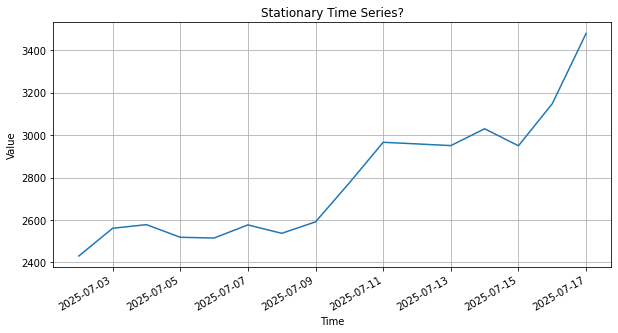

In [5]:
dt_from = '2025-07-01 10:00:00'
dt_to   = '2025-07-19 10:20:00'
ldf = df[(df.index >= dt_from) & (df.index <= dt_to)]
plt.figure(figsize=(10, 5))
plt.plot(ldf.index, ldf["Price"], label="Price")
plt.title('Stationary Time Series?')
plt.xlabel('Time')  
plt.ylabel('Value')
#plt.set_major_locator(mdates.DayLocator(interval=7))  # cada 7 días
plt.gcf().autofmt_xdate()  # Ajusta las fechas automáticamente
plt.grid()
plt.show()

Ver valores ¿Es estacionaria?

In [6]:
ADF_result = adfuller(ldf["Price"])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: 4.714991549596814
p-value: 1.0


No rechazamos la hipótesis nula de que la serie tiene una raíz unitaria y por tanto no es estacionaria. Debemos obtener la diferencia de primer orden. 

In [7]:
ldf.loc[:,['values_diff']] = ldf["Price"].diff()
df_diff1 = ldf.copy()
#Eliminamos el nulo del inicio
df_diff1.dropna(inplace=True)

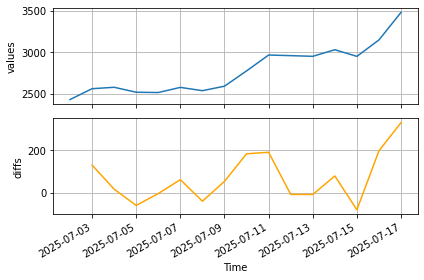

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(ldf["Price"])
ax1.set_xlabel('Time')
ax1.set_ylabel('values')
#ax1.axvspan(450, 500, color='#808080', alpha=0.2)
ax1.grid()
ax2.plot(ldf['values_diff'], color='orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('diffs')
ax2.grid()
#ax2.axvspan(449, 498, color='#808080', alpha=0.2)


fig.autofmt_xdate()
plt.tight_layout()

plt.show()

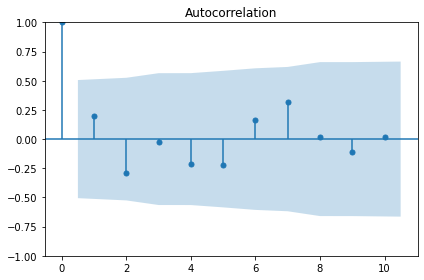

In [9]:
#El primer elemento es NaN, por eso no lo consideramos
plot_acf(df_diff1["values_diff"], lags=10)
plt.tight_layout()
plt.show()
